# Calculating the Expansion Rate of the Universe

Now that you have determined the radial velocities and distances for your set of galaxies, the next step is to calculate the expansion rate of the universe, also known as the Hubble constant (H₀). This will involve plotting the radial velocities of your galaxies against their distances and determining the best-fit line through the data points. The slope of this line will give you an estimate of $H_\circ$.


## Finding the Slope

Let's retrieve our measurement data stored in the Google Sheet. We will then plot the **velocity** vs. **distance** data and fit the slope by eye. This will give us an estimated value for the expansion rate. You will then run some code on your own data to determine the real slope. Remember to record your results in the [Google Sheet](https://docs.google.com/spreadsheets/d/1mVRovTF8C1UJkQakQG_E9emnpJIRb1rdNx6UPNcm3rs/edit?usp=sharing).

In [1]:
from astropy.utils.data import download_file

galaxy_data = download_file("https://docs.google.com/spreadsheets/d/1mVRovTF8C1UJkQakQG_E9emnpJIRb1rdNx6UPNcm3rs/export?format=csv&gid=0")

In [2]:
import pandas as pd
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Select, CustomJS, PolyDrawTool, PolyAnnotation, Label
from bokeh.layouts import column
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
import numpy as np
from astropy.table import Table

output_notebook()

Loading BokehJS ...

In [3]:
# Load the data
data = pd.read_csv(galaxy_data)
data['Hubble Parameter'] = np.ones(len(data['Velocity (km/s)']))
data = data.drop("SDSS ID", axis=1)
data.dropna()

# Create a ColumnDataSource
source = ColumnDataSource(data)

# Unique list of students
students = ['All'] + data['Name'].astype(str).unique().tolist()

# Create a dropdown selector for students
select = Select(title="Select Student", value=students[0], options=students)

# Create a Bokeh figure
x_limits = (-data['Distance (Mpc)'].max() * 0.05, data['Distance (Mpc)'].max() * 1.1)
y_limits = (-data['Velocity (km/s)'].max() * 0.1, data['Velocity (km/s)'].max() * 1.1)
p = figure(title="Galaxy Velocity vs Distance", x_axis_label='Distance (Mpc)', y_axis_label='Velocity (km/s)', x_range=x_limits, y_range=y_limits, height=400, sizing_mode="stretch_width")

# Scatter plot
scatter = p.scatter('Distance (Mpc)', 'Velocity (km/s)', source=source, size=8, color=linear_cmap('Velocity (km/s)', Viridis256, min(data['Velocity (km/s)']), max(data['Velocity (km/s)'])))

# Create a ColumnDataSource for the line
line_source = ColumnDataSource(data=dict(xs=[[]], ys=[[]]))

# Add a line glyph
line_renderer = p.multi_line(xs='xs', ys='ys', source=line_source, line_color='red', line_width=2)

draw_tool = PolyDrawTool(renderers=[line_renderer], num_objects=1)
p.add_tools(draw_tool)
p.toolbar.active_drag = draw_tool

# Define normalized positions (0 to 1 range)
x_norm = 0.1  # 20% of the x-axis range
y_norm = 0.9  # 50% of the y-axis range

# Convert normalized positions to data units
x_pos = x_limits[0] + x_norm * (x_limits[1] - x_limits[0])
y_pos = y_limits[0] + y_norm * (y_limits[1] - y_limits[0])

# Label to display the slope of the line
label = Label(x=x_pos, y=y_pos, x_units='screen', text='Slope: N/A', text_font_size='12pt', text_color='black')
p.add_layout(label)

# JavaScript callback to filter data by student
select_callback = CustomJS(args=dict(source=source, original_source=source.data, line_source=line_source, select=select, label=label), code="""
    const data = source.data;
    const original_data = original_source;
    const student = select.value;

    const filtered_data = Object.keys(data).reduce((acc, key) => {
        acc[key] = [];
        return acc;
    }, {});

    for (let i = 0; i < original_data['Name'].length; i++) {
        if (original_data['Name'][i] === student) {
            for (let key in data) {
                filtered_data[key].push(original_data[key][i]);
            }
        }
    }

    for (let key in data) {
        data[key] = filtered_data[key];
    }
    
    if (student === 'All') {
        for (let key in data) {
            data[key] = original_data[key];
        }
    }

    source.change.emit();
""")

select.js_on_change('value', select_callback)

# JavaScript callback to calculate slope
slope_callback = CustomJS(args=dict(line_source=line_source, tool=draw_tool, label=label), code="""
    // Update the slope label if a line is drawn
    if (line_source.data['xs'].length > 0) {
        const xs = line_source.data['xs'][0];
        const ys = line_source.data['ys'][0];

        if (xs.length >= 2) {
            const slope = (ys[1] - ys[0]) / (xs[1] - xs[0]);
            label.text = `Slope: ${slope.toFixed(2)} (km/s/Mpc)`;
        
            if (xs.length > 2 && xs[0] != xs[1]) {
                console.log("Values are different!")
                tool.active = false;
            }
        }
    }
""")

line_source.js_on_change('data', slope_callback)

# Layout the plot and dropdown
layout = column(select, p, sizing_mode="stretch_width")

# Display the plot
show(layout)

### Fitting the Data with Linear Regression

Linear regression is a way to take a linear model (like a simple line) and fit it to a set of data. In the code block below, enter your name exactly as it appears in the drop down list above. Running the cells will fit a model to the data and print out the true slope. Record the results in the [Google Sheet](https://docs.google.com/spreadsheets/d/1mVRovTF8C1UJkQakQG_E9emnpJIRb1rdNx6UPNcm3rs/edit?usp=sharing).

In [4]:
# Enter your name here exactly as it appears in the dropdown above.
selected_student = "All"

In [9]:
from astropy.modeling.models import Linear1D
from astropy.modeling.fitting import LinearLSQFitter, LevMarLSQFitter

measurement_data = Table.from_pandas(data)

if selected_student != 'All':
    mask = measurement_data['Name'] == selected_student
    measurement_data = measurement_data[mask]
    
distance_data = measurement_data['Distance (Mpc)']
velocity_data = measurement_data['Velocity (km/s)']

model = Linear1D(slope=60, intercept=0)
fitted_model = LinearLSQFitter()(model, distance_data, velocity_data)

In [10]:
print(f"The true slope (expansion rate) measured for {selected_student}: {fitted_model.slope.value:0.3f} (km/s/Mpc).")

The true slope (expansion rate) measured for All: 75.732.


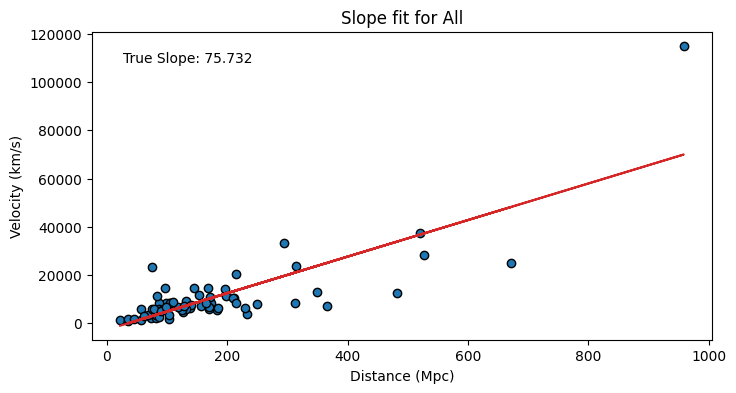

In [12]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(8, 4))

ax.scatter(distance_data, velocity_data, edgecolor='k', label='Measurement Data')
ax.plot(distance_data, fitted_model(distance_data), label='Fitted Model', color='C3')

ax.text(0.05, 0.9, f"True Slope: {fitted_model.slope.value:.3f} (km/s/Mpc)", transform=ax.transAxes)

ax.set(xlabel="Distance (Mpc)", ylabel="Velocity (km/s)", title=f"Slope fit for {selected_student}");

```{admonition} Question
How does your by-eye estimate of the expansion rate compare to the "true" value derived from the model fitting? Why might they be different?
```